# Predict Future Sales 

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn.metrics as metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from itertools import product

import lightgbm as lgb
import xgboost as xgb

import os

In [2]:
train_df = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
test_df= pd.read_csv('competitive-data-science-predict-future-sales/test.csv', index_col='ID')

shops_df = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv', index_col='shop_id')

items_df = pd.read_csv('competitive-data-science-predict-future-sales/items.csv', index_col='item_id')
itemcat_df = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv', index_col='item_category_id')

sample_submission = pd.read_csv('competitive-data-science-predict-future-sales/sample_submission.csv', index_col='ID')

In [3]:
test_df.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [4]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops_df.head()

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


In [6]:
shops_df['city'] = [fragment[0] for fragment in shops_df['shop_name'].str.split()]
shops_df['shop_type'] = [fragment[1] for fragment in shops_df['shop_name'].str.split()]
shops_df

,shop_name,city,shop_type
shop_id,,,
0,"!Якутск Орджоникидзе, 56 фран",!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",Воронеж,"(Плехановская,"
7,"Воронеж ТРЦ ""Максимир""",Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,ТРЦ


In [7]:
#fixing the wrong values 
shops_df.loc[(shops_df.shop_type != 'ТЦ') & (shops_df.shop_type != 'ТРК') & (shops_df.shop_type != 'ТРЦ') & (shops_df.shop_type != 'МТРЦ') & (shops_df.shop_type != 'ТК'), 'shop_type'] = 'ТЦ'
shops_df

,shop_name,city,shop_type
shop_id,,,
0,"!Якутск Орджоникидзе, 56 фран",!Якутск,ТЦ
1,"!Якутск ТЦ ""Центральный"" фран",!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ
6,"Воронеж (Плехановская, 13)",Воронеж,ТЦ
7,"Воронеж ТРЦ ""Максимир""",Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,ТРЦ


In [8]:
len(shops_df.city.values)

60

In [9]:
#encoding the city name to a value for training
enc = LabelEncoder()
result = enc.fit_transform(shops_df.city.values.reshape(60,1))
result

c:\users\hassa\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  0,  1,  2,  3,  4,  5,  5,  5,  6,  7,  7,  8,  9,  9, 10, 11,
       12, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,
       16, 16, 17, 17, 18, 19, 19, 19, 20, 20, 21, 21, 22, 23, 24, 25, 25,
       25, 26, 26, 27, 28, 29, 30, 30, 31])

In [10]:
shops_df['city_enc'] = result

In [11]:
shops_df

,shop_name,city,shop_type,city_enc
shop_id,,,,
0,"!Якутск Орджоникидзе, 56 фран",!Якутск,ТЦ,0
1,"!Якутск ТЦ ""Центральный"" фран",!Якутск,ТЦ,0
2,"Адыгея ТЦ ""Мега""",Адыгея,ТЦ,1
3,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,ТРК,2
4,"Волжский ТЦ ""Волга Молл""",Волжский,ТЦ,3
5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ,4
6,"Воронеж (Плехановская, 13)",Воронеж,ТЦ,5
7,"Воронеж ТРЦ ""Максимир""",Воронеж,ТРЦ,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,ТРЦ,5


In [12]:
#Now do same for shop type 
result = enc.fit_transform(shops_df.shop_type.values.reshape(60,1))
shops_df['shop_type_enc'] = result

c:\users\hassa\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
shops_df

,shop_name,city,shop_type,city_enc,shop_type_enc
shop_id,,,,,
0,"!Якутск Орджоникидзе, 56 фран",!Якутск,ТЦ,0,4
1,"!Якутск ТЦ ""Центральный"" фран",!Якутск,ТЦ,0,4
2,"Адыгея ТЦ ""Мега""",Адыгея,ТЦ,1,4
3,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,ТРК,2,2
4,"Волжский ТЦ ""Волга Молл""",Волжский,ТЦ,3,4
5,"Вологда ТРЦ ""Мармелад""",Вологда,ТРЦ,4,3
6,"Воронеж (Плехановская, 13)",Воронеж,ТЦ,5,4
7,"Воронеж ТРЦ ""Максимир""",Воронеж,ТРЦ,5,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,ТРЦ,5,3


In [14]:
# drop the previous name as data has been encoded
shops_df = shops_df.drop(['shop_name'],axis=1)

In [15]:
shops_df = shops_df.drop(['shop_type'],axis=1)
shops_df = shops_df.drop(['city'],axis=1)

In [16]:
shops_df.head()

,city_enc,shop_type_enc
shop_id,,
0,0,4
1,0,4
2,1,4
3,2,2
4,3,4


Now comming to itemid and category data 

In [17]:
items_df.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [18]:
itemcat_df.head()

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [19]:
itemcat_df['item_d1'] = [split[0].split()[0] for split in itemcat_df.item_category_name.str.split('-')]
itemcat_df['item_d2'] = [split[-1].strip() for split in itemcat_df.item_category_name.str.split('-')]

In [20]:
itemcat_df

,item_category_name,item_d1,item_d2
item_category_id,,,
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,Аксессуары,PS2
2,Аксессуары - PS3,Аксессуары,PS3
3,Аксессуары - PS4,Аксессуары,PS4
4,Аксессуары - PSP,Аксессуары,PSP
...,...,...,...
79,Служебные,Служебные,Служебные
80,Служебные - Билеты,Служебные,Билеты
81,Чистые носители (шпиль),Чистые,Чистые носители (шпиль)


In [21]:
itemcat_df.item_d1.describe()

count       84
unique      15
top       Игры
freq        14
Name: item_d1, dtype: object

In [22]:
itemcat_df.item_d1.unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

### Translated Data for more visualization as I know english

['PC', 'Accessories', 'Tickets', 'Delivery', 'Gaming', 'Games',
       'Maps', 'Movies', 'Books', 'Music', 'Gifts', 'Programs',
       'Service', 'Clean', 'Elements']


In [23]:
itemcat_df.item_d2.describe()

count        84
unique       67
top       Цифра
freq          4
Name: item_d2, dtype: object

In [24]:
itemcat_df.item_d2.unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты (Цифра)', 'Доставка товара',
       'Прочие', 'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! (Цифра)',
       'PSN', 'Windows (Цифра)', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD',
       'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги (Цифра)', 'Аудиокниги 1С', 'Бизнес литература',
       'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры',
       'Настольные игры (компактные)', 'Открытки, наклейки', 'Ра

### Translated Data for more visualization as I know english

['Headsets/Headphones', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Tickets (Digit)', 'Product Delivery',
       'Other', 'Accessories for games', 'Digit', 'Additional editions',
       'Collector's editions', 'Standard editions',
       'Payment Cards (Movies, Music, Games)', 'Live!', 'Live! (Digit)',
       'PSN', 'Windows (Digit)', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD',
       'Collectible', 'Artbooks, Encyclopedias', 'Audiobooks',
       'Audiobooks (Digital)', '1C Audiobooks', 'Business Literature',
       'Comics, manga', 'Computer literature',
       '1C methodological materials', 'Postcards',
       'Educational literature', 'Guidebooks',
       'Fiction', 'Locally produced CD',
       'Branded CD', 'MP3', 'Vinyl', 'Music Video',
       'Gift editions', 'Paraphernalia', 'Gadgets, robots, sports',
       'Soft toys', 'Board games',
       'Board games (compact)', 'Postcards, stickers', 'Development',
       'Certificates, services', 'Souvenirs', 'Souvenirs (hanging)',
       'Bags, Albums, Mouse pads', 'Figurines', '1C:Enterprise 8',
       'MAC (Digit)', 'For Home and Office', 'For Home and Office (Digit)',
       'Training', 'Training (Digit)', 'Service', 'Tickets',
       'Pure carriers (spire)', 'Pure media (piece)',
       'Batteries']

#### So found a specific keyword that is Digit / Цифра, this can also taken into consideration 

In [25]:
itemcat_df['digital'] = 0
itemcat_df.loc[itemcat_df['item_d2'].str.contains('(Цифра)'), 'digital'] = 1
itemcat_df.head(50)

C:\Users\hassa\AppData\Local\Temp/ipykernel_4320/2383758804.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  itemcat_df.loc[itemcat_df['item_d2'].str.contains('(Цифра)'), 'digital'] = 1


,item_category_name,item_d1,item_d2,digital
item_category_id,,,,
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники,0
1,Аксессуары - PS2,Аксессуары,PS2,0
2,Аксессуары - PS3,Аксессуары,PS3,0
3,Аксессуары - PS4,Аксессуары,PS4,0
4,Аксессуары - PSP,Аксессуары,PSP,0
5,Аксессуары - PSVita,Аксессуары,PSVita,0
6,Аксессуары - XBOX 360,Аксессуары,XBOX 360,0
7,Аксессуары - XBOX ONE,Аксессуары,XBOX ONE,0
8,Билеты (Цифра),Билеты,Билеты (Цифра),1


### The digit / Цифр is now preserved in the type of the new field so removing it from main string so that it will be benefit at the time of encoding as it only contain required name nothing else 

In [26]:
itemcat_df.loc[itemcat_df['item_d2'].str.contains('(Цифра)'), 'item_d2'] = itemcat_df['item_d2'].str.rstrip('(Цифра)')

# Now it looks Good 
itemcat_df

C:\Users\hassa\AppData\Local\Temp/ipykernel_4320/478777169.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  itemcat_df.loc[itemcat_df['item_d2'].str.contains('(Цифра)'), 'item_d2'] = itemcat_df['item_d2'].str.rstrip('(Цифра)')


,item_category_name,item_d1,item_d2,digital
item_category_id,,,,
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники,0
1,Аксессуары - PS2,Аксессуары,PS2,0
2,Аксессуары - PS3,Аксессуары,PS3,0
3,Аксессуары - PS4,Аксессуары,PS4,0
4,Аксессуары - PSP,Аксессуары,PSP,0
...,...,...,...,...
79,Служебные,Служебные,Служебные,0
80,Служебные - Билеты,Служебные,Билеты,0
81,Чистые носители (шпиль),Чистые,Чистые носители (шпиль),0


In [27]:
itemcat_df.item_d2.unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты ', 'Доставка товара', 'Прочие',
       'Аксессуары для игр', '', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! ', 'PSN',
       'Windows ', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD', 'Коллекционное',
       'Артбуки, энциклопедии', 'Аудиокниги', 'Аудиокниги ',
       'Аудиокниги 1С', 'Бизнес литература', 'Комиксы, манга',
       'Компьютерная литература', 'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры',
       'Настольные игры (компактные)', 'Открытки, наклейки', 'Развитие',
       'Сертификаты, услуги', '

In [28]:
s = str(itemcat_df.item_d2.unique())

In [29]:
from collections import Counter
line_text = s
freq = Counter(line_text.split()).most_common()
print(freq)

[("'", 7), ("издания'", 4), ("литература'", 4), ("'XBOX", 2), ("'Ray", 2), ("'Аудиокниги", 2), ("1С'", 2), ("'CD", 2), ("производства'", 2), ("'Настольные", 2), ("'Для", 2), ('дома', 2), ('и', 2), ("'Чистые", 2), ('носители', 2), ("['Гарнитуры/Наушники'", 1), ("'PS2'", 1), ("'PS3'", 1), ("'PS4'", 1), ("'PSP'", 1), ("'PSVita'", 1), ("360'", 1), ("ONE'", 1), ("'Билеты", 1), ("'Доставка", 1), ("товара'", 1), ("'Прочие'", 1), ("'Аксессуары", 1), ('для', 1), ("игр'", 1), ("''", 1), ("'Дополнительные", 1), ("'Коллекционные", 1), ("'Стандартные", 1), ("'Карты", 1), ('оплаты', 1), ('(Кино,', 1), ('Музыка,', 1), ("Игры)'", 1), ("'Live!'", 1), ("'Live!", 1), ("'PSN'", 1), ("'Windows", 1), ("'Ray'", 1), ("3D'", 1), ("4K'", 1), ("'DVD'", 1), ("'Коллекционное'", 1), ("'Артбуки,", 1), ("энциклопедии'", 1), ("'Аудиокниги'", 1), ("'Бизнес", 1), ("'Комиксы,", 1), ("манга'", 1), ("'Компьютерная", 1), ("'Методические", 1), ('материалы', 1), ("'Открытки'", 1), ("'Познавательная", 1), ("'Путеводители'", 1)

['Headsets/Headphones', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
'XBOX 360', 'XBOX ONE', 'Tickets', 'Product Delivery', 'Other',
'Accessories for games', ", 'Additional editions',
'Collector's editions', 'Standard editions',
'Payment Cards (Movies, Music, Games)', 'Live!', 'Live! ', 'PSN',
'Windows', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD', 'Collector's',
'Artbooks, Encyclopedias', 'Audiobooks', 'Audiobooks',
'1C Audiobooks', 'Business Literature', 'Comics, Manga',
'Computer literature', '1C methodological materials', 'Postcards',
'Educational literature', 'Guidebooks',
'Fiction', 'Locally produced CD',
'Branded CD', 'MP3', 'Vinyl', 'Music Video',
'Gift editions', 'Paraphernalia', 'Gadgets, robots, sports',
'Soft toys', 'Board games',
'Board games (compact)', 'Postcards, stickers', 'Development',
'Certificates, services', 'Souvenirs', 'Souvenirs (hanging)',
'Bags, Albums, Mouse pads', 'Figurines', '1C:Enterprise 8',
'MAC ', 'For Home and Office', 'For Home and Office', 'Educational',
'Training', 'Service', 'Tickets', 'Pure media (spire)',
'Pure media (piece)', 'Batteries']

In [30]:
sENG = "['Headsets/Headphones', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita', 'XBOX 360', 'XBOX ONE', 'Tickets', 'Product Delivery', 'Other', 'Accessories for games', 'Additional editions', 'Collector's editions', 'Standard editions', 'Payment Cards (Movies, Music, Games)', 'Live!', 'Live! ', 'PSN', 'Windows', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD', 'Collector's', 'Artbooks, Encyclopedias', 'Audiobooks', 'Audiobooks', '1C Audiobooks', 'Business Literature', 'Comics, Manga', 'Computer literature', '1C methodological materials', 'Postcards', 'Educational literature', 'Guidebooks', 'Fiction', 'Locally produced CD', 'Branded CD', 'MP3', 'Vinyl', 'Music Video', 'Gift editions', 'Paraphernalia', 'Gadgets, robots, sports', 'Soft toys', 'Board games', 'Board games (compact)', 'Postcards, stickers', 'Development', 'Certificates, services', 'Souvenirs', 'Souvenirs (hanging)', 'Bags, Albums, Mouse pads', 'Figurines', '1C:Enterprise 8', 'MAC ', 'For Home and Office', 'For Home and Office', 'Educational', 'Training', 'Service', 'Tickets', 'Pure media (spire)', 'Pure media (piece)', 'Batteries']"

In [31]:
from collections import Counter
line_text = sENG
freq = Counter(line_text.split()).most_common()
print(freq)

[("editions',", 4), ("'XBOX", 2), ("'Tickets',", 2), ("games',", 2), ("',", 2), ("'Ray", 2), ("'Audiobooks',", 2), ("'1C", 2), ("literature',", 2), ("CD',", 2), ("'Board", 2), ("'For", 2), ('Home', 2), ('and', 2), ("Office',", 2), ("'Pure", 2), ('media', 2), ("['Headsets/Headphones',", 1), ("'PS2',", 1), ("'PS3',", 1), ("'PS4',", 1), ("'PSP',", 1), ("'PSVita',", 1), ("360',", 1), ("ONE',", 1), ("'Product", 1), ("Delivery',", 1), ("'Other',", 1), ("'Accessories", 1), ('for', 1), ("'Additional", 1), ("'Collector's", 1), ("'Standard", 1), ("'Payment", 1), ('Cards', 1), ('(Movies,', 1), ('Music,', 1), ("Games)',", 1), ("'Live!',", 1), ("'Live!", 1), ("'PSN',", 1), ("'Windows',", 1), ("'Ray',", 1), ("3D',", 1), ("4K',", 1), ("'DVD',", 1), ("'Collector's',", 1), ("'Artbooks,", 1), ("Encyclopedias',", 1), ("Audiobooks',", 1), ("'Business", 1), ("Literature',", 1), ("'Comics,", 1), ("Manga',", 1), ("'Computer", 1), ('methodological', 1), ("materials',", 1), ("'Postcards',", 1), ("'Educational"

## I have used a language converter tool to convert it to a english string[i know english not russian] to look the frequency of each work to get a approximation about which kind of categories can be combined to a single categories, like Audiobook 1C and Audiobook are basically same thing / Для дома и офиса and Для дома и офис are basically same thing / so I have configured some of these that can be combined - >so look at the below code

In [32]:
m1 = (itemcat_df.item_d2 == 'Аудиокниги') | \
        (itemcat_df.item_d2 == 'Аудиокниг') | \
        (itemcat_df.item_d2 == 'Аудиокниги 1С')
itemcat_df.loc[m1, 'item_d2'] = 'Аудиокниги'
m2 = (itemcat_df.item_d2 == 'Открытки') | \
        (itemcat_df.item_d2 == 'Открытки, наклейки')
itemcat_df.loc[m2, 'item_d2'] = 'Открытки'
m3 = (itemcat_df.item_d2 == 'Настольные игры') | \
        (itemcat_df.item_d2 == 'Настольные игры (компактные)')
itemcat_df.loc[m3, 'item_d2'] = 'Настольные игры'
m4 = (itemcat_df.item_d2 == 'Сувениры') | \
        (itemcat_df.item_d2 == 'Сувениры (в навеску)')
itemcat_df.loc[m4, 'item_d2'] = 'Сувениры'
m5 = (itemcat_df.item_d2 == 'Коллекционные издания') | \
        (itemcat_df.item_d2 == 'Коллекционное')
itemcat_df.loc[m5, 'item_d2'] = 'Коллекционное'
m6 = (itemcat_df.item_d2 == 'Для дома и офиса') | \
        (itemcat_df.item_d2 == 'Для дома и офис')
itemcat_df.loc[m6, 'item_d2'] = 'Для дома и офиса'
m7 = (itemcat_df.item_d2 == 'Для дома и офиса') & \
        (itemcat_df.item_d2 == 'Для дома и офис')
itemcat_df.loc[m6, 'item_d2'] = 'Для дома и офиса'

In [33]:
itemcat_df.item_d2.unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты ', 'Доставка товара', 'Прочие',
       'Аксессуары для игр', '', 'Дополнительные издания',
       'Коллекционное', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! ', 'PSN',
       'Windows ', 'Ray', 'Ray 3D', 'Ray 4K', 'DVD',
       'Артбуки, энциклопедии', 'Аудиокниги', 'Аудиокниги ',
       'Бизнес литература', 'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Развитие',
       'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприятие 8',
       'MAC ', 'Для 

In [34]:
items_df.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [35]:
itemcat_df.head()

,item_category_name,item_d1,item_d2,digital
item_category_id,,,,
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники,0
1,Аксессуары - PS2,Аксессуары,PS2,0
2,Аксессуары - PS3,Аксессуары,PS3,0
3,Аксессуары - PS4,Аксессуары,PS4,0
4,Аксессуары - PSP,Аксессуары,PSP,0


Its time to combine items_df and itemcat_df

In [36]:
itemcat_df = itemcat_df.drop(['item_category_name'],axis=1)

In [37]:
itemcat_df

,item_d1,item_d2,digital
item_category_id,,,
0,PC,Гарнитуры/Наушники,0
1,Аксессуары,PS2,0
2,Аксессуары,PS3,0
3,Аксессуары,PS4,0
4,Аксессуары,PSP,0
...,...,...,...
79,Служебные,Служебные,0
80,Служебные,Билеты,0
81,Чистые,Чистые носители (шпиль),0


In [38]:
items_df = items_df.reset_index()
itemcat_df = itemcat_df.reset_index()

In [39]:
itemcat_df = pd.merge(items_df,itemcat_df,on='item_category_id',how='left')

In [40]:
itemcat_df = itemcat_df.drop(['item_name'],axis=1)

In [41]:
itemcat_df

,item_id,item_category_id,item_d1,item_d2,digital
0,0,40,Кино,DVD,0
1,1,76,Программы,Для дома и офиса,1
2,2,40,Кино,DVD,0
3,3,40,Кино,DVD,0
4,4,40,Кино,DVD,0
...,...,...,...,...,...
22165,22165,31,Игры,,1
22166,22166,54,Книги,,1
22167,22167,49,Книги,Методические материалы 1С,0
22168,22168,62,Подарки,"Гаджеты, роботы, спорт",0


### Encoding the values

In [42]:
itemcat_df['item_d1_enc'] = enc.fit_transform(itemcat_df.item_d1.values.reshape(-1,1))

c:\users\hassa\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
itemcat_df

,item_id,item_category_id,item_d1,item_d2,digital,item_d1_enc
0,0,40,Кино,DVD,0,7
1,1,76,Программы,Для дома и офиса,1,11
2,2,40,Кино,DVD,0,7
3,3,40,Кино,DVD,0,7
4,4,40,Кино,DVD,0,7
...,...,...,...,...,...,...
22165,22165,31,Игры,,1,5
22166,22166,54,Книги,,1,8
22167,22167,49,Книги,Методические материалы 1С,0,8
22168,22168,62,Подарки,"Гаджеты, роботы, спорт",0,10


In [44]:
itemcat_df['item_d2_enc'] = enc.fit_transform(itemcat_df.item_d2.values.reshape(-1,1))

c:\users\hassa\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
itemcat_df.tail()

,item_id,item_category_id,item_d1,item_d2,digital,item_d1_enc,item_d2_enc
22165,22165,31,Игры,,1,5,0
22166,22166,54,Книги,,1,8,0
22167,22167,49,Книги,Методические материалы 1С,0,8,40
22168,22168,62,Подарки,"Гаджеты, роботы, спорт",0,10,30
22169,22169,69,Подарки,Сувениры,0,10,55


### Now all the value have been encoded its time to drop the load 
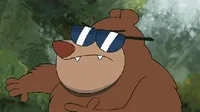

In [46]:
itemcat_df.drop(['item_d1','item_d2'],axis = 1, inplace = True)

In [47]:
itemcat_df

,item_id,item_category_id,digital,item_d1_enc,item_d2_enc
0,0,40,0,7,4
1,1,76,1,11,33
2,2,40,0,7,4
3,3,40,0,7,4
4,4,40,0,7,4
...,...,...,...,...,...
22165,22165,31,1,5,0
22166,22166,54,1,8,0
22167,22167,49,0,8,40
22168,22168,62,0,10,30


# Moving towards the training 

In [48]:
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [49]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [51]:
train_df['date'] = pd.to_datetime(train_df['date'],format='%d.%m.%Y')

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [53]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [54]:
train_df['year'] = train_df.date.dt.year
train_df['month'] = train_df.date.dt.month

In [55]:
train_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10


In [56]:
train_df = train_df.sort_values(by=["date"])

In [57]:
train_df.drop(['date'],axis=1,inplace = True)

In [58]:
(train_df[train_df['item_cnt_day'] < 0])

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
10621,0,19,13086,1499.0,-1.0,2013,1
49083,0,18,6724,299.5,-1.0,2013,1
105843,0,37,9601,849.0,-1.0,2013,1
82413,0,54,3429,2799.0,-1.0,2013,1
7894,0,19,20383,1229.0,-1.0,2013,1
...,...,...,...,...,...,...,...
2894554,33,36,10207,1199.0,-1.0,2015,10
2931176,33,22,8546,1299.0,-1.0,2015,10
2892512,33,38,1846,1199.0,-1.0,2015,10
2902831,33,47,4056,2999.0,-1.0,2015,10


Some item cnt day are negative

Item count sold can't be negative

In [59]:
train_df = train_df.drop(train_df.index[train_df['item_cnt_day'] < 0])

In [60]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
49800,0,18,5823,2500.0,1.0,2013,1
29784,0,27,5573,849.0,1.0,2013,1
35476,0,7,1006,399.0,1.0,2013,1
8330,0,19,17707,899.0,1.0,2013,1
57384,0,14,19548,149.0,1.0,2013,1
...,...,...,...,...,...,...,...
2885098,33,41,21386,169.0,1.0,2015,10
2930981,33,21,988,199.0,1.0,2015,10
2885097,33,41,21377,169.0,1.0,2015,10
2930993,33,22,10207,1199.0,1.0,2015,10


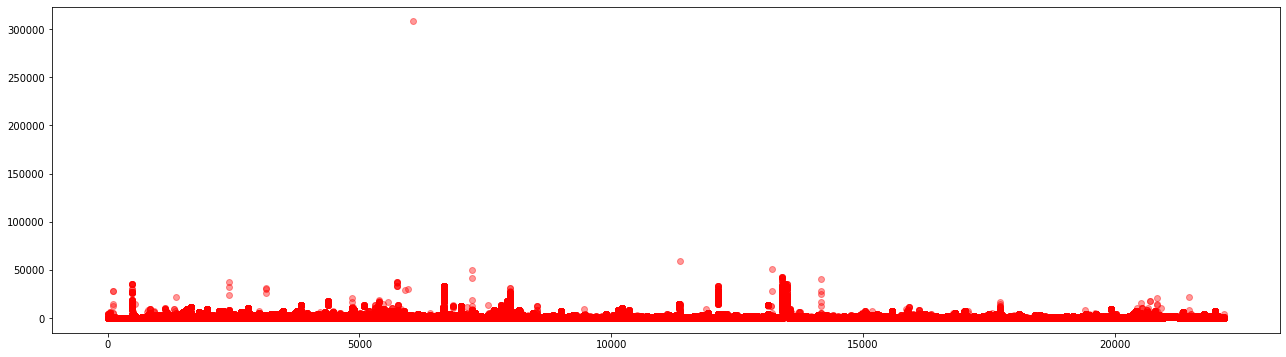

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 6))
plt.scatter('item_id', 'item_price',
            data=train_df,
            marker='o',color="red", alpha=0.4)

plt.show()

In [62]:
train_df[train_df.item_price > 100000]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
1163158,11,12,6066,307980.0,1.0,2013,12


In [63]:
#found a outlier 
train_df.drop(1163158, inplace=True)

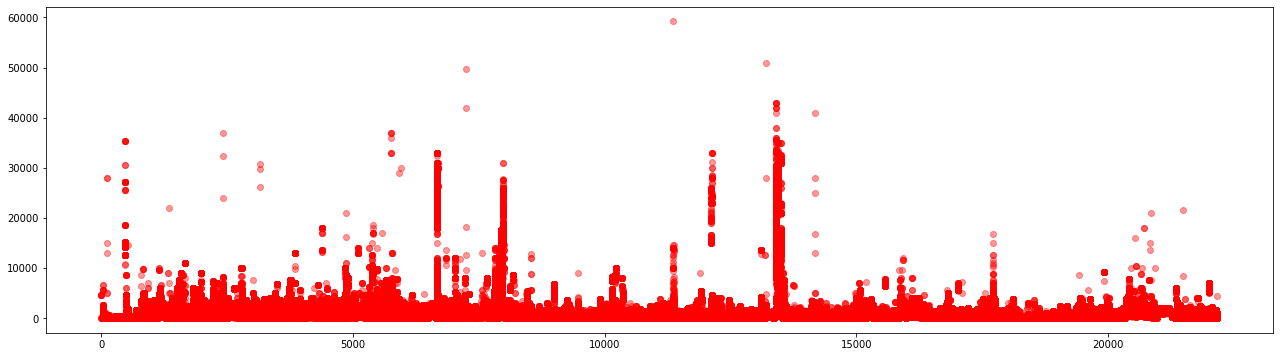

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 6))
plt.scatter('item_id', 'item_price',
            data=train_df,
            marker='o',color="red", alpha=0.4)

plt.show()

In [65]:
train_df[train_df.item_price > 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
49800,0,18,5823,2500.0,1.0,2013,1
29784,0,27,5573,849.0,1.0,2013,1
35476,0,7,1006,399.0,1.0,2013,1
8330,0,19,17707,899.0,1.0,2013,1
57384,0,14,19548,149.0,1.0,2013,1
...,...,...,...,...,...,...,...
2885098,33,41,21386,169.0,1.0,2015,10
2930981,33,21,988,199.0,1.0,2015,10
2885097,33,41,21377,169.0,1.0,2015,10
2930993,33,22,10207,1199.0,1.0,2015,10


In [66]:
train_df[train_df.item_price < 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
484683,4,32,2973,-1.0,1.0,2013,5


Again found a typo

In [67]:
train_df.drop(484683, inplace=True)

In [68]:
train_df.date_block_num.max()

33

In [69]:
train_df.year.unique()

array([2013, 2014, 2015], dtype=int64)

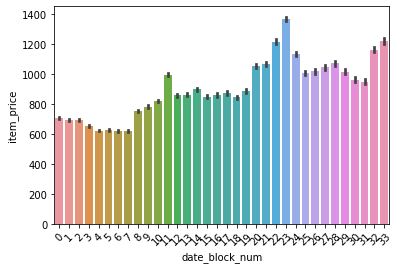

In [70]:
import seaborn as sns

ax = sns.barplot(x="date_block_num", y="item_price", data=train_df)
plt.xticks(rotation=45)
plt.show()

Now one more step further

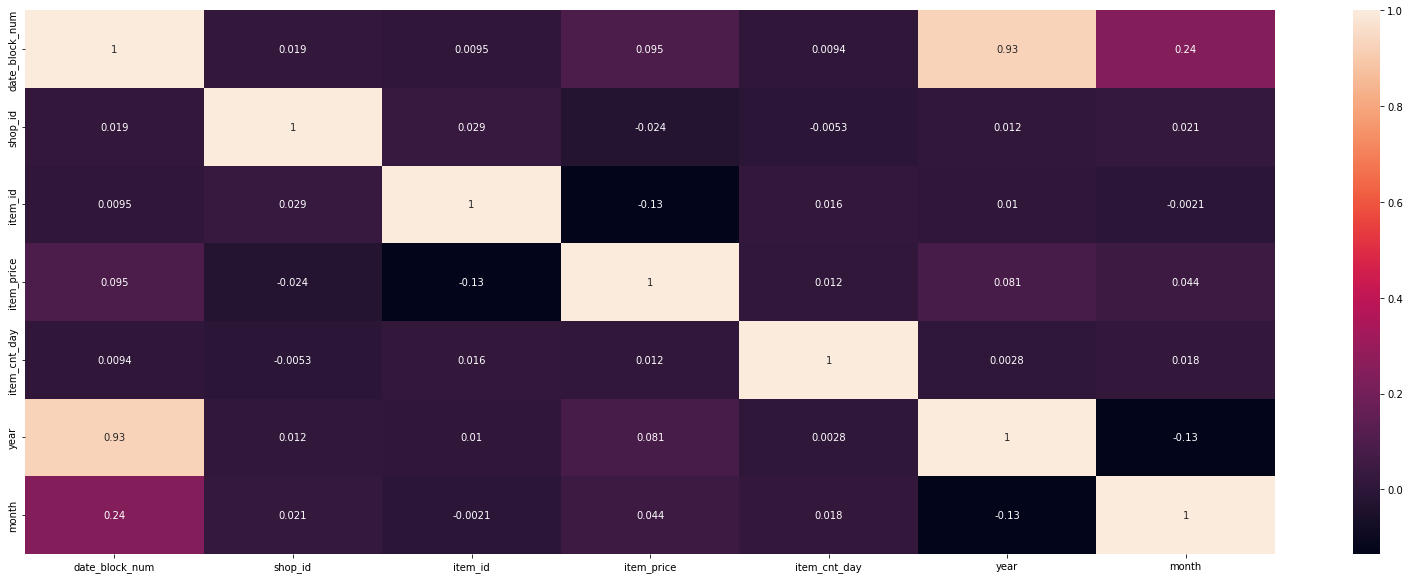

In [71]:
corr = train_df.corr()
plt.figure(figsize=(28,10))
sns.heatmap(corr, annot=True)
plt.show()

In [72]:
train_df.merge(shops_df,how='inner',on='shop_id')

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,city_enc,shop_type_enc
0,0,18,5823,2500.0,1.0,2013,1,12,4
1,0,18,4807,1999.0,1.0,2013,1,12,4
2,0,18,10242,249.0,1.0,2013,1,12,4
3,0,18,9685,58.0,1.0,2013,1,12,4
4,0,18,9620,148.0,1.0,2013,1,12,4
...,...,...,...,...,...,...,...,...,...
2928486,33,36,6504,2499.0,1.0,2015,10,17,3
2928487,33,36,6620,1398.0,1.0,2015,10,17,3
2928488,33,36,7003,199.0,1.0,2015,10,17,3
2928489,33,36,7172,1499.0,1.0,2015,10,17,3


In [73]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
49800,0,18,5823,2500.0,1.0,2013,1
29784,0,27,5573,849.0,1.0,2013,1
35476,0,7,1006,399.0,1.0,2013,1
8330,0,19,17707,899.0,1.0,2013,1
57384,0,14,19548,149.0,1.0,2013,1
...,...,...,...,...,...,...,...
2885098,33,41,21386,169.0,1.0,2015,10
2930981,33,21,988,199.0,1.0,2015,10
2885097,33,41,21377,169.0,1.0,2015,10
2930993,33,22,10207,1199.0,1.0,2015,10


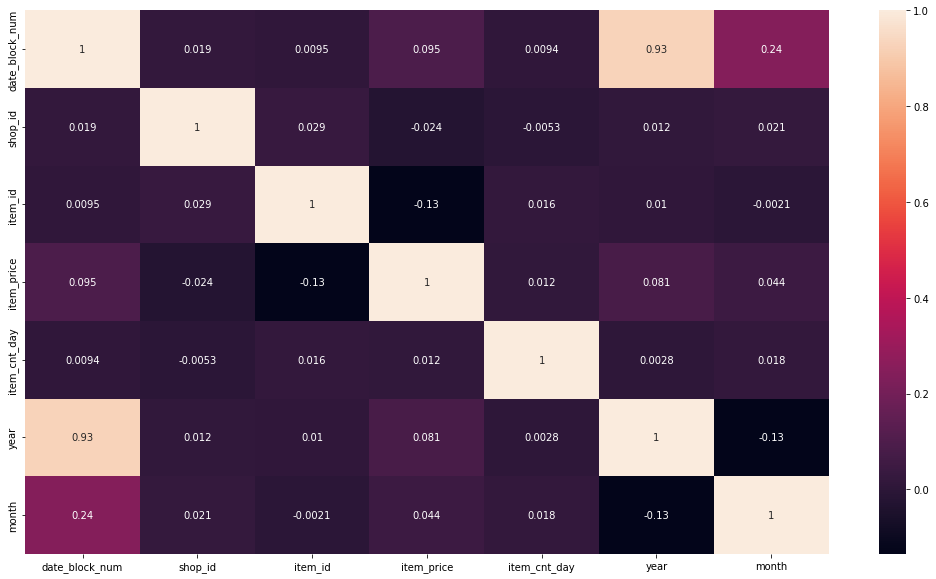

In [74]:
corr = train_df.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr, annot=True)
plt.show()

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928491 entries, 49800 to 2928850
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_price      float64
 4   item_cnt_day    float64
 5   year            int64  
 6   month           int64  
dtypes: float64(2), int64(5)
memory usage: 243.2 MB


In [76]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
49800,0,18,5823,2500.0,1.0,2013,1
29784,0,27,5573,849.0,1.0,2013,1
35476,0,7,1006,399.0,1.0,2013,1
8330,0,19,17707,899.0,1.0,2013,1
57384,0,14,19548,149.0,1.0,2013,1
...,...,...,...,...,...,...,...
2885098,33,41,21386,169.0,1.0,2015,10
2930981,33,21,988,199.0,1.0,2015,10
2885097,33,41,21377,169.0,1.0,2015,10
2930993,33,22,10207,1199.0,1.0,2015,10


In [77]:
train_df=train_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'last','item_cnt_day':'sum'}).reset_index()

In [78]:
train_df=train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

In [79]:
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,127.0,2.0
...,...,...,...,...,...
1608220,33,59,22087,119.0,6.0
1608221,33,59,22088,119.0,2.0
1608222,33,59,22091,179.0,1.0
1608223,33,59,22100,629.0,1.0


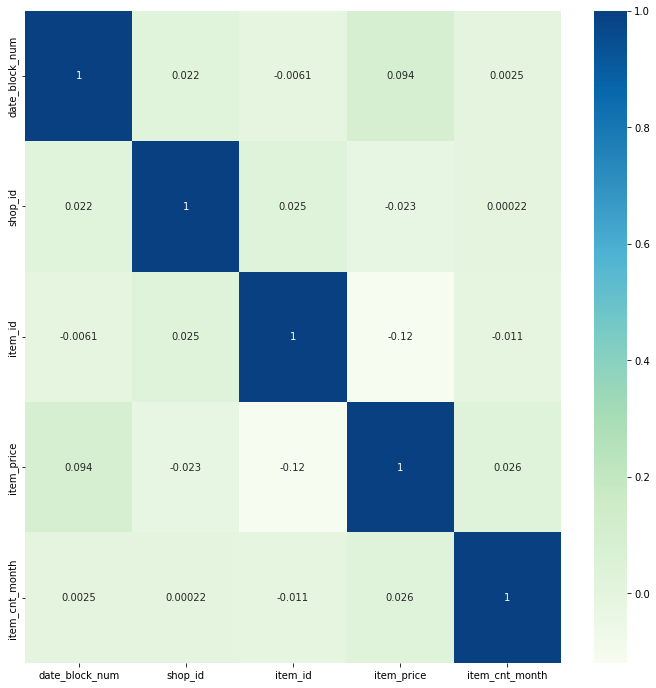

In [80]:
#Calculating Correlation
correlation=train_df.corr()
#Plotting correlation
plt.figure(figsize=(12,12))
corr_heatmap=sns.heatmap(correlation,annot=True,cmap="GnBu")

# Preparing Test Data

In [81]:
#Adding date_block_num to the Test data
test_df['date_block_num']=34
test_df=test_df[['date_block_num','shop_id','item_id']]
print(test_df)

        date_block_num  shop_id  item_id
ID                                      
0                   34        5     5037
1                   34        5     5320
2                   34        5     5233
3                   34        5     5232
4                   34        5     5268
...                ...      ...      ...
214195              34       45    18454
214196              34       45    16188
214197              34       45    15757
214198              34       45    19648
214199              34       45      969

[214200 rows x 3 columns]


In [82]:
item_price=dict(train_df.groupby('item_id')['item_price'].last().reset_index().values)
test_df['item_price']=test_df.item_id.map(item_price)
print(test_df)

        date_block_num  shop_id  item_id  item_price
ID                                                  
0                   34        5     5037      1499.0
1                   34        5     5320         NaN
2                   34        5     5233      1199.0
3                   34        5     5232      1199.0
4                   34        5     5268         NaN
...                ...      ...      ...         ...
214195              34       45    18454        99.0
214196              34       45    16188      1359.0
214197              34       45    15757       229.0
214198              34       45    19648        79.2
214199              34       45      969       198.0

[214200 rows x 4 columns]


In [83]:
test_df['item_price']=test_df['item_price'].fillna(test_df['item_price'].median())
test_df['item_price']

ID
0         1499.0
1          449.0
2         1199.0
3         1199.0
4          449.0
           ...  
214195      99.0
214196    1359.0
214197     229.0
214198      79.2
214199     198.0
Name: item_price, Length: 214200, dtype: float64

In [84]:
x_train=train_df.drop('item_cnt_month',axis=1)
y_train=train_df["item_cnt_month"]
x_test=test_df

In [85]:
x_train.shape,y_train.shape

((1608225, 4), (1608225,))

## Training the Model

In [86]:
linear_model=LinearRegression()
linear_model.fit(x_train,y_train)

LinearRegression()

In [87]:
linear_prediction=linear_model.predict(x_test)

In [88]:
linear_prediction

array([2.42411935, 2.27401941, 2.37992117, ..., 2.14498677, 2.07968031,
       2.30921479])

## Implementing Random Forest Regression

In [89]:
from sklearn.ensemble import RandomForestRegressor
rr_model=RandomForestRegressor(n_estimators=50)
rr_model.fit(x_train,y_train)

RandomForestRegressor(n_estimators=50)

In [90]:
rr_predict=rr_model.predict(x_test)

In [91]:
rr_predict

array([1.48, 1.06, 1.44, ..., 1.  , 1.42, 1.  ])

## Implementing Lasso Regression

In [92]:
from sklearn.linear_model import Lasso
lasso_model=Lasso(alpha=1.0)
lasso_model.fit(x_train,y_train)

Lasso()

In [93]:
#test the model
lasso_predict=lasso_model.predict(x_test)

In [94]:
lasso_predict

array([2.43600058, 2.28640844, 2.39195264, ..., 2.13723664, 2.07217474,
       2.30081825])

## Implementing Ridge Regression

In [95]:
from sklearn.linear_model import Ridge
r_model=Ridge(alpha=1.0)
r_model.fit(x_train,y_train)

Ridge()

In [96]:
r_predict=r_model.predict(x_test)
r_predict

array([2.42411935, 2.27401941, 2.37992117, ..., 2.14498677, 2.07968031,
       2.30921479])

# Now Deep Learning  comes into play

In [97]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [98]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten


with tf.device('/GPU:0'):
    model = Sequential()
        # input layer design 
    model.add(Dense(128, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))

    # internal hidden layers
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # output layer
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # compiling the NN
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Creating a callback function

In [99]:
#callback function 
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss',\
                             verbose = 1, save_best_only = True,\
                             mode ='auto')
callback = [checkpoint]

## My fav just train it

In [100]:
x_train

,date_block_num,shop_id,item_id,item_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,127.0
...,...,...,...,...
1608220,33,59,22087,119.0
1608221,33,59,22088,119.0
1608222,33,59,22091,179.0
1608223,33,59,22100,629.0


In [102]:
model.fit(x_train, y_train, epochs=500, batch_size=321645, validation_split = 0.2, callbacks=callback, verbose=0)


Epoch 00001: val_loss did not improve from 1.47439

Epoch 00002: val_loss did not improve from 1.47439

Epoch 00003: val_loss did not improve from 1.47439

Epoch 00004: val_loss did not improve from 1.47439

Epoch 00005: val_loss did not improve from 1.47439

Epoch 00006: val_loss did not improve from 1.47439

Epoch 00007: val_loss did not improve from 1.47439

Epoch 00008: val_loss did not improve from 1.47439

Epoch 00009: val_loss improved from 1.47439 to 1.42225, saving model to Weights-009--1.42225.hdf5

Epoch 00010: val_loss did not improve from 1.42225

Epoch 00011: val_loss did not improve from 1.42225

Epoch 00012: val_loss did not improve from 1.42225

Epoch 00013: val_loss did not improve from 1.42225

Epoch 00014: val_loss improved from 1.42225 to 1.37703, saving model to Weights-014--1.37703.hdf5

Epoch 00015: val_loss did not improve from 1.37703

Epoch 00016: val_loss did not improve from 1.37703

Epoch 00017: val_loss did not improve from 1.37703

Epoch 00018: val_loss


Epoch 00146: val_loss did not improve from 1.21186

Epoch 00147: val_loss did not improve from 1.21186

Epoch 00148: val_loss did not improve from 1.21186

Epoch 00149: val_loss did not improve from 1.21186

Epoch 00150: val_loss did not improve from 1.21186

Epoch 00151: val_loss did not improve from 1.21186

Epoch 00152: val_loss improved from 1.21186 to 1.19323, saving model to Weights-152--1.19323.hdf5

Epoch 00153: val_loss did not improve from 1.19323

Epoch 00154: val_loss did not improve from 1.19323

Epoch 00155: val_loss did not improve from 1.19323

Epoch 00156: val_loss did not improve from 1.19323

Epoch 00157: val_loss did not improve from 1.19323

Epoch 00158: val_loss did not improve from 1.19323

Epoch 00159: val_loss did not improve from 1.19323

Epoch 00160: val_loss did not improve from 1.19323

Epoch 00161: val_loss did not improve from 1.19323

Epoch 00162: val_loss did not improve from 1.19323

Epoch 00163: val_loss did not improve from 1.19323

Epoch 00164: val


Epoch 00293: val_loss improved from 1.16831 to 1.16581, saving model to Weights-293--1.16581.hdf5

Epoch 00294: val_loss did not improve from 1.16581

Epoch 00295: val_loss did not improve from 1.16581

Epoch 00296: val_loss did not improve from 1.16581

Epoch 00297: val_loss did not improve from 1.16581

Epoch 00298: val_loss did not improve from 1.16581

Epoch 00299: val_loss did not improve from 1.16581

Epoch 00300: val_loss did not improve from 1.16581

Epoch 00301: val_loss did not improve from 1.16581

Epoch 00302: val_loss did not improve from 1.16581

Epoch 00303: val_loss did not improve from 1.16581

Epoch 00304: val_loss did not improve from 1.16581

Epoch 00305: val_loss did not improve from 1.16581

Epoch 00306: val_loss did not improve from 1.16581

Epoch 00307: val_loss did not improve from 1.16581

Epoch 00308: val_loss improved from 1.16581 to 1.16310, saving model to Weights-308--1.16310.hdf5

Epoch 00309: val_loss did not improve from 1.16310

Epoch 00310: val_loss


Epoch 00447: val_loss did not improve from 1.15934

Epoch 00448: val_loss did not improve from 1.15934

Epoch 00449: val_loss improved from 1.15934 to 1.15916, saving model to Weights-449--1.15916.hdf5

Epoch 00450: val_loss did not improve from 1.15916

Epoch 00451: val_loss did not improve from 1.15916

Epoch 00452: val_loss improved from 1.15916 to 1.15788, saving model to Weights-452--1.15788.hdf5

Epoch 00453: val_loss did not improve from 1.15788

Epoch 00454: val_loss did not improve from 1.15788

Epoch 00455: val_loss did not improve from 1.15788

Epoch 00456: val_loss did not improve from 1.15788

Epoch 00457: val_loss did not improve from 1.15788

Epoch 00458: val_loss did not improve from 1.15788

Epoch 00459: val_loss did not improve from 1.15788

Epoch 00460: val_loss did not improve from 1.15788

Epoch 00461: val_loss did not improve from 1.15788

Epoch 00462: val_loss did not improve from 1.15788

Epoch 00463: val_loss did not improve from 1.15788

Epoch 00464: val_loss

In [103]:
Predict_by_deepNeuralNet=model.predict(x_test)

In [104]:
print(Predict_by_deepNeuralNet)

[[1.0099105]
 [1.0086334]
 [1.0083847]
 ...
 [1.0076103]
 [1.0035766]
 [1.0337113]]


### Save it 

In [105]:
sample_submission.reset_index()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [106]:
#creating and saving the output file almost done
sample_submission.item_cnt_month=Predict_by_deepNeuralNet[:,0]

In [107]:
sample_submission.head()

,item_cnt_month
ID,
0,1.009910
1,1.008633
2,1.008385
3,1.008375
4,1.008576


In [108]:
sample_submission.reset_index()

,ID,item_cnt_month
0,0,1.009910
1,1,1.008633
2,2,1.008385
3,3,1.008375
4,4,1.008576
...,...,...
214195,214195,1.000542
214196,214196,1.008479
214197,214197,1.007610
214198,214198,1.003577


In [109]:
sample_submission.to_csv("competitive-data-science-predict-future-sales-output/Sales_Prediction_OUT.csv")

# Done